In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
#Loading metadata
root_path = './COVID19/CORD19'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

cord_uid                                       sha source_x  \
0  xqhn0vbp  1e1286db212100993d03cc22374b624f7caee956      PMC   
1  gi6uaa83  8ae137c8da1607b3a8e4c946c07ca8bda67f88ac      PMC   
2  le0ogx1s                                       NaN      PMC   
3  fy4w7xz8  0104f6ceccf92ae8567a0102f89cbb976969a774      PMC   
4  0qaoam29  5b68a553a7cbbea13472721cd1ad617d42b40c26      PMC   

                                               title                      doi  \
0  Airborne rhinovirus detection and effect of ul...    10.1186/1471-2458-3-5   
1    Discovering human history from stomach bacteria  10.1186/gb-2003-4-5-213   
2     A new recruit for the army of the men of death  10.1186/gb-2003-4-7-113   
3  Association of HLA class I with severe acute r...    10.1186/1471-2350-4-9   
4   A double epidemic model for the SARS propagation   10.1186/1471-2334-3-19   

       pmcid pubmed_id license  \
0  PMC140314  12525263   no-cc   
1  PMC156578  12734001   no-cc   
2  PMC193621  12844350   no-cc   
3  PMC212558  12969506   no-cc   
4  PMC222908  12964944   no-cc   

                                            abstract publish_time  \
0  BACKGROUND: Rhinovirus, the most common cause ...   2003-01-13   
1  Recent analyses of human pathogens have reveal...   2003-04-28   
2  The army of the men of death, in John Bunyan's...   2003-06-27   
3  BACKGROUND: The human leukocyte antigen (HLA) ...   2003-09-12   
4  BACKGROUND: An epidemic of a Severe Acute Resp...   2003-09-10   

                                             authors            journal  \
0  Myatt, Theodore A; Johnston, Sebastian L; Rudn...  BMC Public Health   
1                                   Disotell, Todd R        Genome Biol   
2                                  Petsko, Gregory A        Genome Biol   
3  Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...      BMC Med Genet   
4  Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine     BMC Infect Dis   

  Microsoft Academic Paper ID WHO #Covidence  has_pdf_parse  \
0                         NaN            NaN           True   
1                         NaN            NaN           True   
2                         NaN            NaN          False   
3                         NaN            NaN           True   
4                         NaN            NaN           True   

   has_pmc_xml_parse  full_text_file  \
0               True  custom_license   
1               True  custom_license   
2               True  custom_license   
3               True  custom_license   
4               True  custom_license   

                                                 url  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...

In [4]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     51078 non-null  object
 1   sha                          38022 non-null  object
 2   source_x                     51078 non-null  object
 3   title                        50920 non-null  object
 4   doi                          47741 non-null  object
 5   pmcid                        41082 non-null  object
 6   pubmed_id                    37861 non-null  object
 7   license                      51078 non-null  object
 8   abstract                     42352 non-null  object
 9   publish_time                 51070 non-null  object
 10  authors                      48891 non-null  object
 11  journal                      46368 non-null  object
 12  Microsoft Academic Paper ID  964 non-null    object
 13  WHO #Covidence               17

In [5]:
#Fetch all of the JSON file path
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

59311

In [6]:
#Create a Helper Function that adds a break after every word when its character length reaches a certain amount

class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0015023cc06b5362d332b3baf348d11567ca2fbb: word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a si... VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structura...


In [7]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [8]:
#Load the data into a DataFrame
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 59311
Processing index: 5931 of 59311
Processing index: 11862 of 59311
Processing index: 17793 of 59311
Processing index: 23724 of 59311
Processing index: 29655 of 59311
Processing index: 35586 of 59311
Processing index: 41517 of 59311
Processing index: 47448 of 59311
Processing index: 53379 of 59311
Processing index: 59310 of 59311


paper_id                          doi  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb    10.1101/2020.01.10.901801   
1  00340eea543336d54adda18236424de6a5e91c9d  10.1101/2020.03.16.20034470   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76  10.1101/2020.02.11.20022111   
3  00911cf4f99a3d5ae5e5b787675646a743574496    10.1101/2020.03.26.009001   
4  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b               10.1101/634600   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                      
3  The fast accumulation of viral metagenomic dat...   
4  Infectious bronchitis (IB) causes significant ...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   
3  Metagenomic sequencing, which allows us to dir...   
4  Infectious bronchitis (IB), which is caused by...   

                                             authors  \
0   Joseph C. Ward.  Lidia Lasecka-Dykes.  Chris<...   
1   Carla Mavian.  Simone Marini.  Costanza Manes...   
2   Hanchu Zhou.  Jianan Yang.  Kaichen Tang. <br...   
3                            Jiayu Shang.  Yanni Sun   
4   Salman L. Butt.  Eric C. Erwood.  Jian Zhang....   

                                               title journal  \
0   The RNA pseudoknots in foot-and-mouth disease...     NaN   
1   Regaining perspective on SARS-CoV-2<br>molecu...     NaN   
2   Healthcare-resource-adjusted<br>vulnerabiliti...     NaN   
3   CHEER: hierarCHical taxonomic<br>classificati...     NaN   
4   Real-time, MinION-based, amplicon<br>sequenci...     NaN   

                                    abstract_summary  
0   word count: 194 22 Text word count: 5168 23 2...  
1   During the past three months, a new coronavir...  
2                                      Not provided.  
3   The fast accumulation of viral metagenomic<br...  
4   Infectious bronchitis (IB) causes<br>signific...

In [9]:
#Feature Engineering - add word count columns for both Abstract and Body_Text
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

paper_id                          doi  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb    10.1101/2020.01.10.901801   
1  00340eea543336d54adda18236424de6a5e91c9d  10.1101/2020.03.16.20034470   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76  10.1101/2020.02.11.20022111   
3  00911cf4f99a3d5ae5e5b787675646a743574496    10.1101/2020.03.26.009001   
4  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b               10.1101/634600   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                      
3  The fast accumulation of viral metagenomic dat...   
4  Infectious bronchitis (IB) causes significant ...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   
3  Metagenomic sequencing, which allows us to dir...   
4  Infectious bronchitis (IB), which is caused by...   

                                             authors  \
0   Joseph C. Ward.  Lidia Lasecka-Dykes.  Chris<...   
1   Carla Mavian.  Simone Marini.  Costanza Manes...   
2   Hanchu Zhou.  Jianan Yang.  Kaichen Tang. <br...   
3                            Jiayu Shang.  Yanni Sun   
4   Salman L. Butt.  Eric C. Erwood.  Jian Zhang....   

                                               title journal  \
0   The RNA pseudoknots in foot-and-mouth disease...     NaN   
1   Regaining perspective on SARS-CoV-2<br>molecu...     NaN   
2   Healthcare-resource-adjusted<br>vulnerabiliti...     NaN   
3   CHEER: hierarCHical taxonomic<br>classificati...     NaN   
4   Real-time, MinION-based, amplicon<br>sequenci...     NaN   

                                    abstract_summary  abstract_word_count  \
0   word count: 194 22 Text word count: 5168 23 2...                  241   
1   During the past three months, a new coronavir...                  175   
2                                      Not provided.                    0   
3   The fast accumulation of viral metagenomic<br...                  139   
4   Infectious bronchitis (IB) causes<br>signific...                 1647   

   body_word_count  body_unique_words  
0             1728                705  
1             2549               1072  
2              755                377  
3             5188               1354  
4             4003               1185

In [10]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36009 entries, 0 to 36008
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             36009 non-null  object
 1   doi                  35672 non-null  object
 2   abstract             36009 non-null  object
 3   body_text            36009 non-null  object
 4   authors              35413 non-null  object
 5   title                35973 non-null  object
 6   journal              34277 non-null  object
 7   abstract_summary     36009 non-null  object
 8   abstract_word_count  36009 non-null  int64 
 9   body_word_count      36009 non-null  int64 
 10  body_unique_words    36009 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 3.0+ MB


In [11]:
df_covid['abstract'].describe(include='all')

count     36009
unique    26249
top            
freq       9704
Name: abstract, dtype: object

In [12]:
#As you can see from the discrepency between total count and unique there are duplicates so 
#let's get rid of them

df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     35987
unique    26249
top            
freq       9694
Name: abstract, dtype: object

In [13]:
df_covid['body_text'].describe(include='all')

count                                                 35987
unique                                                35981
top       Human respiratory syncytial virus (HRSV) is th...
freq                                                      2
Name: body_text, dtype: object

In [14]:
#Nevermind, seems like it's jsut articles without abstracts Let's take a look at the data though
df_covid.head()

paper_id                          doi  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb    10.1101/2020.01.10.901801   
1  00340eea543336d54adda18236424de6a5e91c9d  10.1101/2020.03.16.20034470   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76  10.1101/2020.02.11.20022111   
3  00911cf4f99a3d5ae5e5b787675646a743574496    10.1101/2020.03.26.009001   
4  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b               10.1101/634600   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                      
3  The fast accumulation of viral metagenomic dat...   
4  Infectious bronchitis (IB) causes significant ...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   
3  Metagenomic sequencing, which allows us to dir...   
4  Infectious bronchitis (IB), which is caused by...   

                                             authors  \
0   Joseph C. Ward.  Lidia Lasecka-Dykes.  Chris<...   
1   Carla Mavian.  Simone Marini.  Costanza Manes...   
2   Hanchu Zhou.  Jianan Yang.  Kaichen Tang. <br...   
3                            Jiayu Shang.  Yanni Sun   
4   Salman L. Butt.  Eric C. Erwood.  Jian Zhang....   

                                               title journal  \
0   The RNA pseudoknots in foot-and-mouth disease...     NaN   
1   Regaining perspective on SARS-CoV-2<br>molecu...     NaN   
2   Healthcare-resource-adjusted<br>vulnerabiliti...     NaN   
3   CHEER: hierarCHical taxonomic<br>classificati...     NaN   
4   Real-time, MinION-based, amplicon<br>sequenci...     NaN   

                                    abstract_summary  abstract_word_count  \
0   word count: 194 22 Text word count: 5168 23 2...                  241   
1   During the past three months, a new coronavir...                  175   
2                                      Not provided.                    0   
3   The fast accumulation of viral metagenomic<br...                  139   
4   Infectious bronchitis (IB) causes<br>signific...                 1647   

   body_word_count  body_unique_words  
0             1728                705  
1             2549               1072  
2              755                377  
3             5188               1354  
4             4003               1185

In [15]:
# Will be working with body_text and generate links using DOI
df_covid.describe()

abstract_word_count  body_word_count  body_unique_words
count         35987.000000     35987.000000       35987.000000
mean            160.526718      4705.964932        1424.665713
std             168.344114      6946.446025        1173.292905
min               0.000000         1.000000           1.000000
25%               0.000000      2371.500000         898.000000
50%             158.000000      3645.000000        1237.000000
75%             235.000000      5449.500000        1677.000000
max            4767.000000    260378.000000       38298.000000

In [16]:
#Data Pre-Processing
df = df_covid.sample(10000, random_state=42)
del df_covid

In [17]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9304 entries, 5158 to 16359
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             9304 non-null   object
 1   doi                  9304 non-null   object
 2   abstract             9304 non-null   object
 3   body_text            9304 non-null   object
 4   authors              9304 non-null   object
 5   title                9304 non-null   object
 6   journal              9304 non-null   object
 7   abstract_summary     9304 non-null   object
 8   abstract_word_count  9304 non-null   int64 
 9   body_word_count      9304 non-null   int64 
 10  body_unique_words    9304 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 872.2+ KB


In [18]:
#We need to handle multiple languages
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|█████████████████████████████████████████████████████████████████████████████| 9304/9304 [00:50<00:00, 183.01it/s]


In [19]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 9304

{'de': 28, 'en': 9085, 'es': 75, 'fr': 99, 'it': 3, 'nl': 9, 'pl': 1, 'pt': 4}


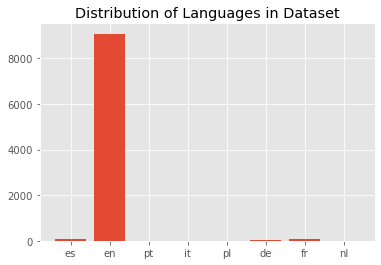

In [20]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [21]:
#I'm just going to drop the ones whose language is not English
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9085 entries, 5158 to 16359
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             9085 non-null   object
 1   doi                  9085 non-null   object
 2   abstract             9085 non-null   object
 3   body_text            9085 non-null   object
 4   authors              9085 non-null   object
 5   title                9085 non-null   object
 6   journal              9085 non-null   object
 7   abstract_summary     9085 non-null   object
 8   abstract_word_count  9085 non-null   int64 
 9   body_word_count      9085 non-null   int64 
 10  body_unique_words    9085 non-null   int64 
 11  language             9085 non-null   object
dtypes: int64(3), object(9)
memory usage: 922.7+ KB


In [22]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

In [23]:
#There are 'stopwords' that are common words that act as noise when clustering, let's remove those
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['‘d',
 'it',
 'before',
 'keep',
 'indeed',
 'should',
 'somehow',
 'name',
 'my',
 'nor']

In [24]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [25]:
#Now we use the spacy library to create a function that will convert text to lower case, remove
#punctuation, and stopwords. 
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [26]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

C:\Users\Shane\AppData\Roaming\Python\Python37\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████████████████████████████████████████████████████| 9085/9085 [53:17<00:00,  2.84it/s]


count      9085.000000
mean       4575.056467
std        4673.886096
min           6.000000
25%        2533.000000
50%        3772.000000
75%        5497.000000
max      155786.000000
Name: body_word_count, dtype: float64

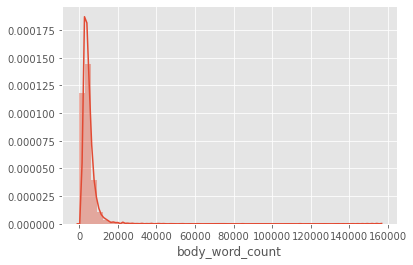

In [27]:
#Let's take a look at the wordcount in the papers
import seaborn as sns

sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count     9085.000000
mean      1416.221794
std        884.270300
min          6.000000
25%        944.000000
50%       1265.000000
75%       1691.000000
max      19746.000000
Name: body_unique_words, dtype: float64

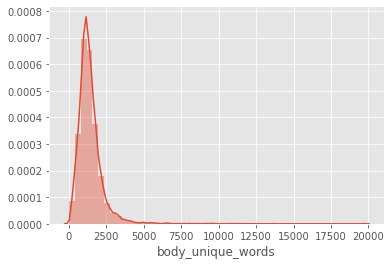

In [28]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

In [29]:
#Most papers seem to be ~5000 words in length. Let's start Vectorization ie. tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [30]:
text = df['processed_text'].values
# max_features = df['body_unique_words'].max()

X = vectorize(text, 2 ** 12)

In [31]:
#PCA and Clustering
# We will see how much we can reduce dimensions while keeping 95% variance.
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(9085, 2115)

In [32]:
#k-means will be run on vectorized text. Given the number of clusters, k, k-means will
#categorize each vector by taking the mean distance to a randomly initialized centroid.
#centroids are updated iteratively.
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))


KeyboardInterrupt: 

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [33]:
#Run k-means
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [34]:
#Dimensionality reduction with t-SNE
#We use it to reduce our high dimensional features vector to 2 dimensions. 
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 9085 samples in 15.415s...
[t-SNE] Computed neighbors for 9085 samples in 470.406s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9085
[t-SNE] Computed conditional probabilities for sample 2000 / 9085
[t-SNE] Computed conditional probabilities for sample 3000 / 9085
[t-SNE] Computed conditional probabilities for sample 4000 / 9085
[t-SNE] Computed conditional probabilities for sample 5000 / 9085
[t-SNE] Computed conditional probabilities for sample 6000 / 9085
[t-SNE] Computed conditional probabilities for sample 7000 / 9085
[t-SNE] Computed conditional probabilities for sample 8000 / 9085
[t-SNE] Computed conditional probabilities for sample 9000 / 9085
[t-SNE] Computed conditional probabilities for sample 9085 / 9085
[t-SNE] Mean sigma: 0.378699
[t-SNE] KL divergence after 50 iterations with early exaggeration: 81.369705
[t-SNE] KL divergence after 1000 iterations: 1.826897


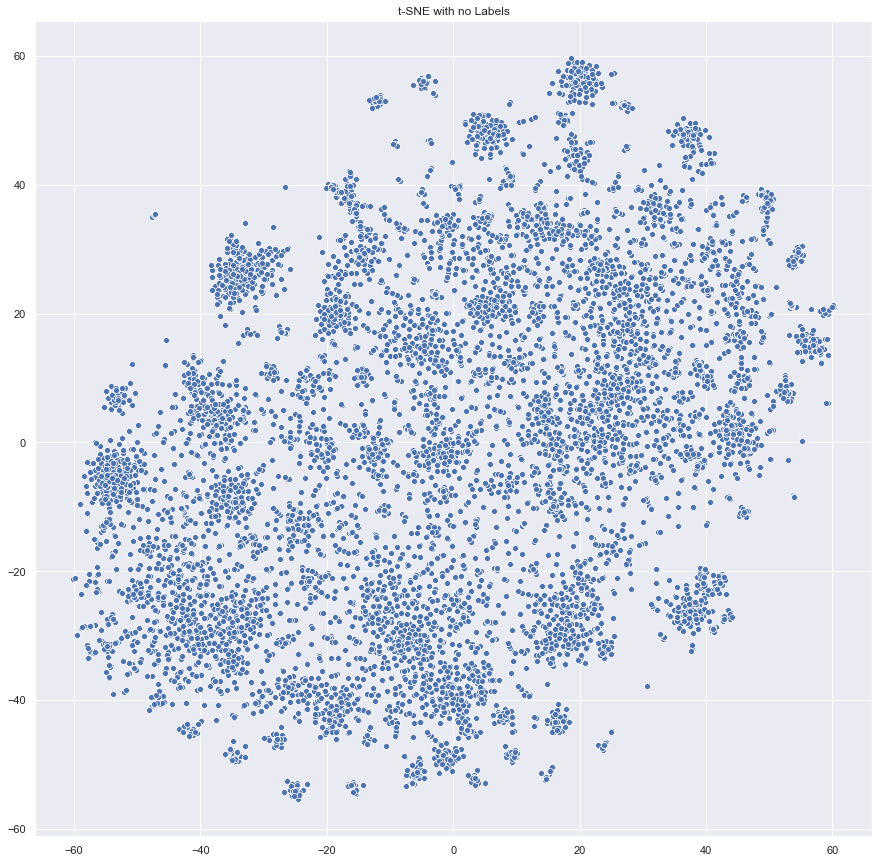

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

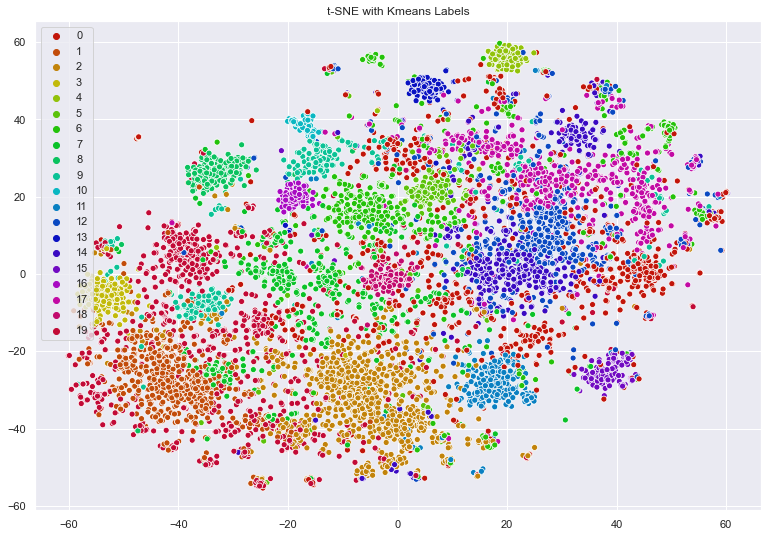

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [37]:
#Interesting that both k-means and t-SNE were able to find independent clusters despite being run independently
#This shows that there is structure within the literature and this structuer can be observed and measured

#Now let's find the most significant words in each of the clusters. We are using LDA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [38]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [39]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [40]:
len(vectorized_data)

20

In [41]:
# Topic Modeling through LDA - a generative statistical model that allows sets of words to be
#explained by a shared topic
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20


lda_models = []

for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [42]:
#for each cluster, we create a corresponding LDA model in the previous step. Now we fit_transform all
#the LDA models to their respective cluster vectors
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [43]:
#extract the keywords from each cluster
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [44]:
#append list of keywords for single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [45]:
all_keywords[0][:10]

['compound',
 'antibody',
 'virus',
 'serum',
 'group',
 'day',
 'activity',
 'surface',
 'acid',
 'min']

In [46]:
len(all_keywords)

20

In [47]:
#since it took forever to do the vectorization and t-SNE, let's save the outputs for future use
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [48]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

In [49]:
#after running kmeans, the data is now labeled. Now we test how well the labels are fitted through 
#classification. 

# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [50]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 7268
X_test size: 1817 



In [51]:
#create stochastic gradient descent classifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  89.007 %
     Precision:  91.061 %
        Recall:  90.863 %
      F1 score:  90.907 %


In [52]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 90.325 %


In [53]:
#plotting the data
import os

# change into lib directory to load plot python scripts
main_path = os.getcwd()
lib_path = './lib/'
os.chdir(lib_path)

In [88]:
# required libraries for plot
from plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
from call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [89]:
# go back
os.chdir(main_path)

In [90]:
import os

topic_path = 'topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

In [94]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend_label = 'labels')
plot.legend.background_fill_alpha = 0.6

Loading BokehJS ...

In [114]:
# STYLE
slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "stretch_width"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

In [115]:
# LAYOUT OF THE PAGE
l = layout([
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('t-sne_covid-19_interactive.html')
show(l)